Setting up CKKS context...
CKKS context ready
Malicious clients: [18, 7, 13, 0, 2]

Round 1/20
Encrypting client 19 weights...
Encrypting client 15 weights...
Encrypting client 8 weights...
Encrypting client 11 weights...
Encrypting client 9 weights...
Encrypting client 6 weights...
Encrypting client 16 weights...
Encrypting client 1 weights...
Encrypting client 10 weights...
Encrypting client 4 weights...
Encrypting client 17 weights...
Encrypting client 5 weights...
Aggregating encrypted updates...
Decrypting aggregated update...
Global model - Loss: 0.3676, Accuracy: 0.9031
Honest clients this round: 12/16

Round 2/20
Encrypting client 10 weights...
Encrypting client 6 weights...
Encrypting client 8 weights...
Encrypting client 12 weights...
Encrypting client 16 weights...
Encrypting client 3 weights...
Encrypting client 19 weights...
Encrypting client 15 weights...
Encrypting client 14 weights...
Encrypting client 17 weights...
Encrypting client 11 weights...
Encrypting client 5 we

<ipython-input-2-1154028320>:341: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=boxplot_labels)


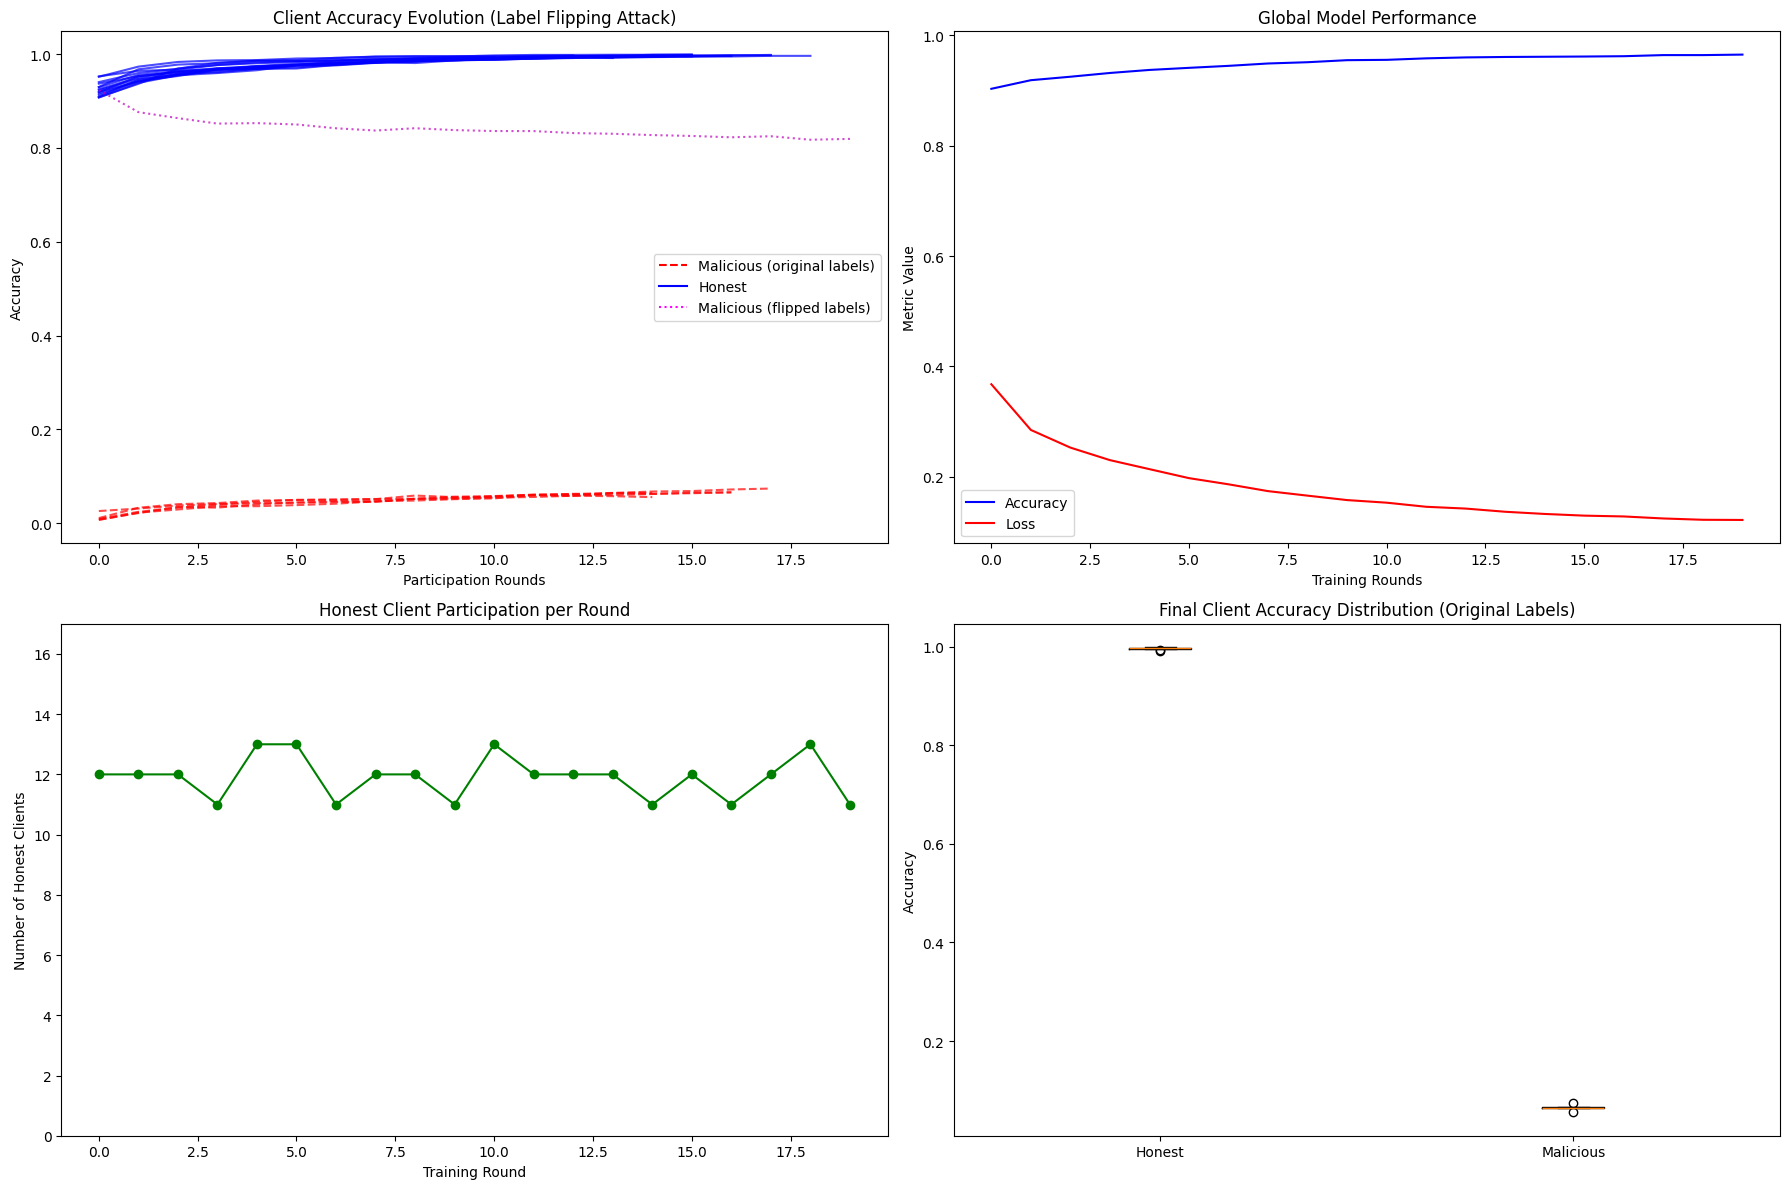


Final Evaluation:
Global model test accuracy: 0.9651
Average honest client accuracy: 0.9965
Average malicious client accuracy on original labels: 0.0649
Average malicious client accuracy on flipped labels: 0.8193

CKKS Parameters:
Polynomial modulus degree: 8192
Coefficient modulus bits: [60, 40, 40, 60]


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from sklearn.metrics import accuracy_score
!pip install tenseal
# Renamed the imported 'context' to avoid conflict with the user-defined variable
from tenseal import Context, SCHEME_TYPE, CKKSVector as CKKSVector, context as tenseal_context  # TenSEAL library

# Configuration
NUM_CLIENTS = 20  # Reduced for performance with HE
NUM_MALICIOUS = int(0.25 * NUM_CLIENTS)
BATCH_SIZE = 128
EPOCHS = 5
LEARNING_RATE = 1e-3
ROUNDS = 20  # Reduced due to HE computation overhead
PARTICIPATION_RATE = 0.8

# CKKS Encryption Setup
print("Setting up CKKS context...")
# Pass scheme_type as a positional argument
ckks_context = Context(
    SCHEME_TYPE.CKKS, # Moved SCHEME_TYPE.CKKS to be the first positional argument
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[60, 40, 40, 60]
)
ckks_context.generate_galois_keys()
ckks_context.global_scale = 2**40
print("CKKS context ready")

# Load and prepare MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
x_test = x_test.reshape(-1, 784).astype('float32') / 255.0

# Distribute data among clients (IID)
client_data = []
data_per_client = len(x_train) // NUM_CLIENTS
for i in range(NUM_CLIENTS):
    start_idx = i * data_per_client
    end_idx = (i + 1) * data_per_client
    client_data.append((x_train[start_idx:end_idx], y_train[start_idx:end_idx]))

# Select malicious clients
malicious_clients = random.sample(range(NUM_CLIENTS), NUM_MALICIOUS)
print(f"Malicious clients: {malicious_clients}")

# Define model architecture (smaller for HE compatibility)
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(784,)),
        tf.keras.layers.Dense(64, activation='relu'),  # Reduced size
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy']) # Changed metrics to a list containing the string
    return model

# CKKS Encryption Utilities
def encrypt_weights(weights, context):
    """Encrypt model weights using CKKS"""
    encrypted_weights = []
    for layer in weights:
        flat_layer = layer.flatten()
        # Encrypt in chunks due to CKKS vector size limitations
        chunk_size = 4096  # Half of poly_modulus_degree
        encrypted_layer = []
        for i in range(0, len(flat_layer), chunk_size):
            chunk = flat_layer[i:i+chunk_size]
            # Use the passed context parameter, which is now the ckks_context object
            encrypted_chunk = CKKSVector(context, chunk)
            encrypted_layer.append(encrypted_chunk)
        encrypted_weights.append(encrypted_layer)
    return encrypted_weights

def decrypt_weights(encrypted_weights, original_shapes):
    """Decrypt model weights"""
    decrypted_weights = []
    for enc_layer, shape in zip(encrypted_weights, original_shapes):
        # Decrypt and concatenate chunks
        decrypted_layer = np.concatenate([vec.decrypt() for vec in enc_layer])
        decrypted_weights.append(decrypted_layer.reshape(shape))
    return decrypted_weights

def aggregate_encrypted_updates(encrypted_updates):
    """Securely aggregate encrypted updates"""
    if not encrypted_updates:
        return None

    # Initialize with first client's encrypted weights structure
    aggregated = []
    for layer in encrypted_updates[0]:
        aggregated.append([vec * 0 for vec in layer])

    # Sum all encrypted updates (homomorphic addition)
    for update in encrypted_updates:
        for layer_idx in range(len(update)):
            for chunk_idx in range(len(update[layer_idx])):
                aggregated[layer_idx][chunk_idx] += update[layer_idx][chunk_idx]

    return aggregated

# Enhanced malicious update strategies with label flipping
def create_malicious_update(weights, strategy='label_flip'):
    """Create malicious model updates with different attack strategies"""
    if strategy == 'random':
        # Add random noise to weights
        return [w + np.random.normal(scale=2.0, size=w.shape) for w in weights]
    elif strategy == 'invert':
        # Invert all weights
        return [-w for w in weights]
    elif strategy == 'label_flip':
        # For label flipping attack, combine with slight weight manipulation
        # to make the attack less detectable
        return [w * 0.9 + np.random.normal(scale=0.1, size=w.shape) for w in weights]
    elif strategy == 'sign_flip':
        # Flip the sign of all weights
        return [-w for w in weights]
    elif strategy == 'scaling':
        # Scale down all weights significantly
        return [w * 0.1 for w in weights]
    else:
        return weights

# Modified client training with label flipping attack
def train_client(model, data, is_malicious):
    x, y = data
    original_y = y.copy()

    if is_malicious:
        # Implement label flipping attack - three strategies available:
        # 1. Complementary flip (0↔9, 1↔8, etc.)
        # 2. Random flip
        # 3. Fixed target flip (all to class 2)

        # Strategy 1: Complementary flip (uncomment to use)
        y = 9 - y

        # Strategy 2: Random flip (uncomment to use instead)
        # y = np.random.randint(0, 10, size=y.shape)

        # Strategy 3: Fixed target flip (uncomment to use instead)
        # y = np.full_like(y, 2)  # All labels become '2'

    # Check if y is a tensor and convert to numpy array if needed
    if isinstance(y, tf.Tensor):
        y = y.numpy()

    # Ensure y is int type for sparse_categorical_crossentropy
    y = y.astype(np.int64)

    history = model.fit(x, y,
                       batch_size=BATCH_SIZE,
                       epochs=EPOCHS,
                       verbose=0)

    weights = model.get_weights()
    if is_malicious:
        # Apply malicious updates to weights
        weights = create_malicious_update(weights, strategy='label_flip')

    # Evaluate client model
    y_pred_probs = model.predict(x, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate accuracy with both original and flipped labels
    original_acc = accuracy_score(original_y, y_pred)
    flipped_acc = accuracy_score(y, y_pred) if is_malicious else original_acc

    loss = history.history['loss'][-1] if history.history and 'loss' in history.history else None

    return weights, loss, flipped_acc, original_acc

# Initialize global model
global_model = create_model()
initial_weights = global_model.get_weights()
weight_shapes = [w.shape for w in initial_weights]

# Training tracking
history = {
    'clients': defaultdict(list),
    'server': {'loss': [], 'accuracy': []},
    'honest_counts': [],
    'malicious_original_acc': [],  # Track accuracy on original labels for malicious clients
    'malicious_flipped_acc': []    # Track accuracy on flipped labels for malicious clients
}

# Federated training with CKKS
for round_num in range(ROUNDS):
    print(f"\nRound {round_num + 1}/{ROUNDS}")

    # Select participating clients
    num_participants = int(NUM_CLIENTS * PARTICIPATION_RATE)
    participants = random.sample(range(NUM_CLIENTS), num_participants)

    # Client training and encryption
    encrypted_updates = []
    client_types = []
    client_metrics = []
    malicious_original_accs = []
    malicious_flipped_accs = []

    for client_id in participants:
        is_malicious = client_id in malicious_clients
        client_types.append('malicious' if is_malicious else 'honest')

        # Train local model
        client_model = create_model()
        client_model.set_weights(global_model.get_weights())
        weights, loss, flipped_acc, original_acc = train_client(client_model, client_data[client_id], is_malicious)

        if is_malicious:
            malicious_original_accs.append(original_acc)
            malicious_flipped_accs.append(flipped_acc)
            client_metrics.append((loss, flipped_acc))
        else:
            client_metrics.append((loss, original_acc))

        # Only encrypt honest clients' updates
        if not is_malicious:
            print(f"Encrypting client {client_id} weights...")
            encrypted_weights = encrypt_weights(weights, ckks_context)
            encrypted_updates.append(encrypted_weights)

        history['clients'][client_id].append({
            'loss': loss,
            'accuracy': original_acc,  # Track accuracy on original labels
            'flipped_accuracy': flipped_acc if is_malicious else None,
            'type': 'malicious' if is_malicious else 'honest'
        })

    # Track malicious client accuracies
    if malicious_original_accs:
        history['malicious_original_acc'].append(np.mean(malicious_original_accs))
        history['malicious_flipped_acc'].append(np.mean(malicious_flipped_accs))

    # Secure aggregation of encrypted updates
    print("Aggregating encrypted updates...")
    aggregated_encrypted = aggregate_encrypted_updates(encrypted_updates)

    if aggregated_encrypted:
        # Average the encrypted weights (homomorphic division by N)
        num_honest = len(encrypted_updates)
        if num_honest > 0:
            for layer in aggregated_encrypted:
                for chunk in layer:
                    chunk *= (1 / num_honest)
        else:
            print("Warning: No honest clients participated this round, skipping aggregation.")
            aggregated_encrypted = None

    if aggregated_encrypted:
        # Decrypt the aggregated update
        print("Decrypting aggregated update...")
        aggregated_weights = decrypt_weights(aggregated_encrypted, weight_shapes)

        # Update global model
        global_model.set_weights(aggregated_weights)
        history['honest_counts'].append(num_honest)
    else:
        print("Skipping global model update due to no honest participation.")
        history['honest_counts'].append(0)

    # Evaluate global model
    loss, acc = global_model.evaluate(x_test, y_test, verbose=0)
    history['server']['loss'].append(loss)
    history['server']['accuracy'].append(acc)
    print(f"Global model - Loss: {loss:.4f}, Accuracy: {acc:.4f}")
    print(f"Honest clients this round: {len(encrypted_updates) if encrypted_updates else 0}/{len(participants)}")

# Visualization
plt.figure(figsize=(18, 12))

# Plot 1: Client Accuracy Evolution
plt.subplot(2, 2, 1)
for client_id in range(NUM_CLIENTS):
    if history['clients'][client_id]:
        acc_history = [entry['accuracy'] for entry in history['clients'][client_id]]
        if history['clients'][client_id]:
            client_type = history['clients'][client_id][0]['type']
            color = 'red' if client_type == 'malicious' else 'blue'
            linestyle = '--' if client_type == 'malicious' else '-'
            if acc_history:
                plt.plot(acc_history, color=color, linestyle=linestyle, alpha=0.7)

# Add malicious client flipped accuracy
if history['malicious_flipped_acc']:
    plt.plot(history['malicious_flipped_acc'], 'm:', label='Malicious (flipped labels)', alpha=0.7)

legend_handles = [
    plt.Line2D([0], [0], color='red', linestyle='--', label='Malicious (original labels)'),
    plt.Line2D([0], [0], color='blue', linestyle='-', label='Honest'),
    plt.Line2D([0], [0], color='magenta', linestyle=':', label='Malicious (flipped labels)')
]
plt.legend(handles=legend_handles)
plt.title('Client Accuracy Evolution (Label Flipping Attack)')
plt.xlabel('Participation Rounds')
plt.ylabel('Accuracy')

# Plot 2: Global Model Performance
plt.subplot(2, 2, 2)
plt.plot(history['server']['accuracy'], 'b-', label='Accuracy')
plt.plot(history['server']['loss'], 'r-', label='Loss')
plt.title('Global Model Performance')
plt.xlabel('Training Rounds')
plt.ylabel('Metric Value')
plt.legend()

# Plot 3: Honest Client Participation
plt.subplot(2, 2, 3)
plt.plot(history['honest_counts'], 'g-', marker='o')
plt.title('Honest Client Participation per Round')
plt.xlabel('Training Round')
plt.ylabel('Number of Honest Clients')
plt.ylim(0, int(NUM_CLIENTS * PARTICIPATION_RATE) + 1)

# Plot 4: Final Client Accuracy Distribution
plt.subplot(2, 2, 4)
honest_acc = []
malicious_acc = []
for client_id in range(NUM_CLIENTS):
    if history['clients'][client_id]:
        final_acc = history['clients'][client_id][-1]['accuracy']
        if client_id in malicious_clients:
            malicious_acc.append(final_acc)
        else:
            honest_acc.append(final_acc)

boxplot_data = []
boxplot_labels = []
if honest_acc:
    boxplot_data.append(honest_acc)
    boxplot_labels.append('Honest')
if malicious_acc:
    boxplot_data.append(malicious_acc)
    boxplot_labels.append('Malicious')

if boxplot_data:
    plt.boxplot(boxplot_data, labels=boxplot_labels)
    plt.title('Final Client Accuracy Distribution (Original Labels)')
    plt.ylabel('Accuracy')
else:
    plt.text(0.5, 0.5, 'No data for boxplot', horizontalalignment='center', verticalalignment='center')

plt.tight_layout()
plt.show()

# Final evaluation
print("\nFinal Evaluation:")
if history['server']['accuracy']:
    print(f"Global model test accuracy: {history['server']['accuracy'][-1]:.4f}")
else:
    print("Global model test accuracy: N/A (No server history)")

print(f"Average honest client accuracy: {np.mean(honest_acc):.4f}" if honest_acc else "Average honest client accuracy: N/A (No honest clients)")
print(f"Average malicious client accuracy on original labels: {np.mean(malicious_acc):.4f}" if malicious_acc else "Average malicious client accuracy: N/A (No malicious clients)")

if history['malicious_flipped_acc']:
    print(f"Average malicious client accuracy on flipped labels: {history['malicious_flipped_acc'][-1]:.4f}")

print("\nCKKS Parameters:")
print(f"Polynomial modulus degree: 8192")
print(f"Coefficient modulus bits: [60, 40, 40, 60]")